# Corrélation #

## Corrélation par famille ##

Il y a 6 catégories que l'on a repéré dans le dataset. Il s'agit de firstorder, glcm, glrlm, glszm, gldm et ngtdm.

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np
from scipy.stats import linregress, skew
%matplotlib widget
%matplotlib widget


In [ ]:
df = pd.read_csv("multislice_excel_basic.csv", sep=';')

In [ ]:
df = pd.read_csv("multislice_excel_basic.csv", sep=';')
categories = ['firstorder', "texture"]
df_num = df.select_dtypes(include='number')

for cat in categories:
    #Sélection colonne dans une catégorie
    if cat != "texture":
        df_temp = df_num.filter(like=cat)
        
    else:
        texture = ['glcm', 'glrlm', 'glszm', 'gldm', 'ngtdm']
        cols = []
        for cat in texture:
            cols += [col for col in df.columns if f'{cat}' in col]
        df_temp = df_num[cols]

    corr_matrix = df_temp.corr()
    #Affichage
    plt.figure(figsize=(15, 12))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, fmt=".2f")
    title = "Matrice de corrélation (Pearson):" + cat
    plt.title(title)
    plt.tight_layout()
    plt.show()
    

## Méthode ACP ##

Mise en place de la méthode ACP par famille

In [ ]:
n = 2
df_components = []
for cat in categories:
    #Sélection colonne dans une catégorie
    if cat != "texture":
        df_temp = df_num.filter(like=cat)
        corr_matrix = df_temp.corr()
    else:
        texture = ['glcm', 'glrlm', 'glszm', 'gldm', 'ngtdm']
        cols = []
        for cat in texture:
            cols += [col for col in df.columns if f'{cat}' in col]
        df_temp = df_num[cols]
    corr_matrix = df_temp.corr()

    X = df_temp

    # Étape 2 : Imputation des NaN
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)

    # Étape 3 : Standardisation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    # Étape 4 : ACP
    pca = PCA(n_components=min(n, X_scaled.shape[1]))
    X_pca = pca.fit_transform(X_scaled)

    # Étape 5 : Stocker dans un DataFrame avec noms clairs
    df_pca = pd.DataFrame(X_pca, columns=[f'{cat}_PC{i+1}' for i in range(X_pca.shape[1])])
    df_components.append(df_pca)
    # Affichage
    plt.figure(figsize=(6, 5))
    if 'classe_name' in df.columns:
        for label in df['classe_name'].unique():
            mask = df['classe_name'] == label
            plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=label, alpha=0.6)
        plt.legend()
    else:
        plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f"ACP - {cat.upper()}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrer pour le patient 1 et la classe CHC
df_patient_chc = df[(df['patient_num'] == 1) & (df['classe_name'] == 'CHC')].sort_values('slice_num')

# Colonnes firstorder
shape_cols = [col for col in df.columns if col.startswith('original_shape2D_')]

# Valeurs de phases (assumées comme étant dans la colonne 'temps_inj')
phases = ['ART', 'PORT', 'VEIN', 'TARD']

# Pour chaque variable
for col in shape_cols:
    fig, axes = plt.subplots(1, 4, figsize=(22, 5), sharey=False, facecolor='#FFFDFA')
    fig.patch.set_facecolor('#FFFDFA')
    for i, phase in enumerate(phases):
        df_filtered = df_patient_chc[df_patient_chc['temps_inj'] == phase]
        sns.lineplot(
            data=df_filtered,
            x='slice_num',
            y=col,
            marker='o',
            ax=axes[i]
        )

        axes[i].set_title(phase)
        axes[i].set_xlabel("Slice")
        axes[i].set_ylabel(col)
        axes[i].grid(True)
        axes[i].set_facecolor('#FFFDFA')

    fig.suptitle(f"{col} - Patient 1 - CHC", fontsize=16)
    fig.subplots_adjust(top=0.85, wspace=0.3)
    plt.show()

## Formatage des données ##

Cette partie a pour objectif de déduire des métriques à partir des variations des données en fonction des slices. 

In [ ]:
import pandas as pd
from scipy.stats import linregress, skew
import numpy as np

df = pd.read_csv("multislice_excel_basic.csv", sep=";")

# Définir les familles de variables à analyser
families = ['firstorder', 'glcm', 'glrlm', 'glszm', 'gldm', 'ngtdm', 'shape2D']
feature_cols = [col for col in df.columns if any(col.startswith(f"original_{fam}_") for fam in families)]

# Fonction d'extraction des métriques sur la dérivée discrète
def extract_derivative_metrics(x, y):
    if len(y) < 3 or pd.isnull(y).all():
        return {
            'mean_deriv': None, 'std_deriv': None,
            'slope_deriv': None, 'amplitude_deriv': None,
            'skewness_deriv': None, 'energy_deriv': None
        }
    dy = np.diff(y)
    slope, _, _, _, _ = linregress(range(len(dy)), dy)
    return {
        'mean_deriv': dy.mean(),
        'std_deriv': dy.std(),
        'slope_deriv': slope,
        'amplitude_deriv': dy.max() - dy.min(),
        'skewness_deriv': skew(dy),
        'energy_deriv': np.sum(dy ** 2)
    }

# Itération par phase / patient
temps_inj_list = df['temps_inj'].dropna().unique()
rows = []

for phase in temps_inj_list:
    df_phase = df[df['temps_inj'] == phase]
    for (patient_num, classe_name), df_patient in df_phase.groupby(['patient_num', 'classe_name']):
        df_patient = df_patient.sort_values('slice_num')
        x = df_patient['slice_num'].values
        row = {
            'patient_num': patient_num,
            'classe_name': classe_name,
            'temps_inj': phase
        }
        
        for col in feature_cols:
            y = df_patient[col].values
            try:
                metrics = extract_derivative_metrics(x, y)
                for metric_name, value in metrics.items():
                    row[f"{col}_{metric_name}"] = value
            except Exception as e:
                print(f"Erreur pour colonne: {col}, patient: {patient_num}, erreur: {e}")
        
        rows.append(row)

In [ ]:
# Conversion en DataFrame
df_metrics_wide = pd.DataFrame(rows)
df_classes = df[['patient_num', 'classe_name', 'temps_inj']].drop_duplicates(subset=['patient_num', 'temps_inj', 'classe_name'])
df_metrics_wide = df_metrics_wide.merge(df_classes, on=['patient_num','temps_inj','classe_name' ], how='left')


# Supprimer les patients avec classe "Mixtes"
df_metrics_wide = df_metrics_wide[df_metrics_wide['classe_name'].str.lower() != 'mixtes']

# Supprimer les doublons selon la clé primaire
df_unique = df_metrics_wide.drop_duplicates(subset=['classe_name', 'patient_num'])

# Compter les patients par classe et phase (temps_inj)
counts = df_unique.groupby(['classe_name']).size().reset_index(name='nb_patients')

# Afficher proprement
print(counts)
# Aperçu
df_metrics_wide.to_csv("differentiel.csv", index=False)

### Matrice de Corrélation avec le nouveau DataSet ###

In [ ]:
df = pd.read_csv("radiomiques_multislice.csv", sep=';')
categories = ['firstorder', "texture"]
metrics = ['mean1', 'std1', 'slope1', 'amplitude1', 'skewness1']
df_num = df_metrics_wide

for cat in categories:
    for metric in metrics:
        #Sélection colonne dans une catégorie
        if cat != "texture":
            cols = [col for col in df.columns if f'{cat}' in col and f'{metric}' in col]
            df_temp = df_num.loc[:, df_num.columns.str.contains(cat) & df_num.columns.str.contains(metric)]
            
        else:
            texture = ['glcm', 'glrlm', 'glszm', 'gldm', 'ngtdm']
            df_temp = df_num.loc[:, df_num.columns[df_num.columns.str.contains(metric) & df_num.columns.str.contains('|'.join(texture))]]

        corr_matrix = df_temp.corr()
        #Affichage
        plt.figure(figsize=(15, 12))
        sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, fmt=".2f")
        title = "Matrice de corrélation (Pearson):" + cat + " " + metric
        plt.title(title)
        plt.tight_layout()
        plt.show()
    

## ACP ##

In [ ]:
for cat in categories:
    for metric in metrics:
        #Sélection colonne dans une catégorie
        if cat != "texture":
            df_temp = df_metrics_wide.loc[:, df_metrics_wide.columns.str.contains(cat) & df_metrics_wide.columns.str.contains(metric)]
            
        else:
            texture = ['glcm', 'glrlm', 'glszm', 'gldm', 'ngtdm']
            df_temp = df_metrics_wide.loc[:, df_metrics_wide.columns[df_metrics_wide.columns.str.contains(metric) & df_metrics_wide.columns.str.contains('|'.join(texture))]]
        corr_matrix = df_temp.corr()


        # Étape 1 : Imputation des valeurs manquantes (si besoin)
        X = df_metrics_wide.drop(columns=['patient_num', 'classe_name'], errors='ignore')
        X_imputed = SimpleImputer(strategy='mean').fit_transform(X)

        # Étape 2 : Standardisation
        X_scaled = StandardScaler().fit_transform(X_imputed)

        # Étape 3 : ACP
        pca = PCA(n_components=3)
        X_pca = pca.fit_transform(X_scaled)

        # Construction DataFrame avec labels
        df_pca_3d = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
        df_pca_3d['classe_name'] = df_metrics_wide['classe_name'].values

        # Plot 3D
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        for label in df_pca_3d['classe_name'].unique():
            mask = df_pca_3d['classe_name'] == label
            ax.scatter(
                df_pca_3d.loc[mask, 'PC1'],
                df_pca_3d.loc[mask, 'PC2'],
                df_pca_3d.loc[mask, 'PC3'],
                label=label,
                alpha=0.6
            )

        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        ax.set_title("ACP 3D sur les métriques patients")
        ax.legend()
        plt.tight_layout()
        plt.show()

#### ACP sélection des variables ####

Le code précédent avait pour objectif de montrer une projection 3D des 3 composantes principales. 
On va maintenant passer à 10 composantes principales et essayer d'obtenir une variance expliquée à 95%

In [ ]:
import matplotlib.pyplot as plt
df = pd.read_csv("wide.csv", sep=";")
# Supprimer toutes les lignes où la classe est "mixte"


X = df.drop(columns=['patient_num', 'classe_name', 'temps_inj'], errors='ignore')
X_imputed = SimpleImputer(strategy='mean').fit_transform(X)

X_scaled = StandardScaler().fit_transform(X_imputed)
pca = PCA(n_components=25)
X_pca = pca.fit_transform(X_scaled)

explained_var = pca.explained_variance_ratio_

# Plot
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained_var) + 1), explained_var * 100)
plt.xlabel("Composantes principales")
plt.ylabel("Variance expliquée (%)")
plt.title("Variance expliquée par composante")
plt.grid(True)
plt.tight_layout()
plt.show()

Puis, entrainement avec RandomForest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Encodage des classes
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['classe_name'])

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, stratify=y, test_size=0.2, random_state=42)
print(y_test)

rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

weights = {'CHC': 1.0, 'CCK': 1000.0}  # tu peux aller jusqu'à 50 ou + si nécessaire

weights_rf = {
    i: weights[c] for i, c in enumerate(label_encoder.classes_)
}

clf = RandomForestClassifier(n_estimators=100, class_weight=weights_rf, random_state=42)
clf.fit(X_train, y_train)


# Prédictions
y_pred = clf.predict(X_test)

# Rapport avec noms des classes
print(classification_report(
    y_test,
    y_pred,
    labels=[0, 1],  # ordre explicite des labels numériques
    target_names=label_encoder.inverse_transform([0, 1])  # noms dans le bon ordre
))
print(label_encoder.classes_)  # ['CCK' 'CHC']
print(np.unique(y_test))       # [1 0] ← si l’ordre est inversé, le problème est confirmé


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage avec les noms des classes
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vraies classes')
plt.title('Matrice de confusion - Random Forest')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement du fichier CSV contenant les métriques de dérivées
df = pd.read_csv("wide.csv", sep = ";")

# Suppression des colonnes non numériques ou identifiants
X = df.drop(columns=['patient_num', 'classe_name', 'temps_inj'], errors='ignore')

# Nettoyage : suppression colonnes contenant que des NaN ou un seul niveau
X = X.dropna(axis=1, how='all')
X = X.loc[:, X.nunique() > 1]

# Encodage des classes
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['classe_name'])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Modèle Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# Prédictions
y_pred = clf.predict(X_test)

# Rapport de classification
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.tight_layout()
plt.show()

# Afficher les 20 variables les plus importantes
importances = clf.feature_importances_
indices = np.argsort(importances)[-20:][::-1]  # top 20
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top 20 variables importantes")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Exemple : charger les deux datasets
df1 = pd.read_csv("differentiel.csv")
df2 = pd.read_csv("radiomiques_global.csv", sep = ";")

# Fusion des deux datasets sur les trois colonnes clés
df_merged = pd.merge(df1, df2, on=['patient_num', 'classe_name', 'temps_inj'], how='inner')
df_merged.to_csv("global_multi.csv", index=False)

## Taux de survie ##

In [1]:
import pandas as pd

# Chargement du fichier CSV (modifie le chemin si nécessaire)
df = pd.read_csv("descriptif_patients.csv", sep=';')

# Extraction du numéro de classe (en supposant que c’est le début du champ)

# Sélection des colonnes utiles
df_filtered = df[['classe_name', 'patient_num', 'Age_at_disease', 'Death']]
df1 = pd.read_csv("long_diff.csv", sep=";")
# Affichage ou export
print(df_filtered.head())
# df_filtered.to_csv("filtered.csv", index=False)

  classe_name  patient_num Age_at_disease  Death
0         CCK           10             62    1.0
1         CCK           11             57    0.0
2         CCK           12             58    1.0
3         CCK           13             65    1.0
4         CCK           14             64    1.0


In [2]:
df = pd.merge(df1, df_filtered, on=['patient_num', 'classe_name'], how='inner')
df.to_csv("survie.csv", index= False)


### Random forest sur le taux de survie ###

/var/folders/2m/d8w21tmd00xblj27xtg459l80000gp/T/ipykernel_89924/1194845977.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)


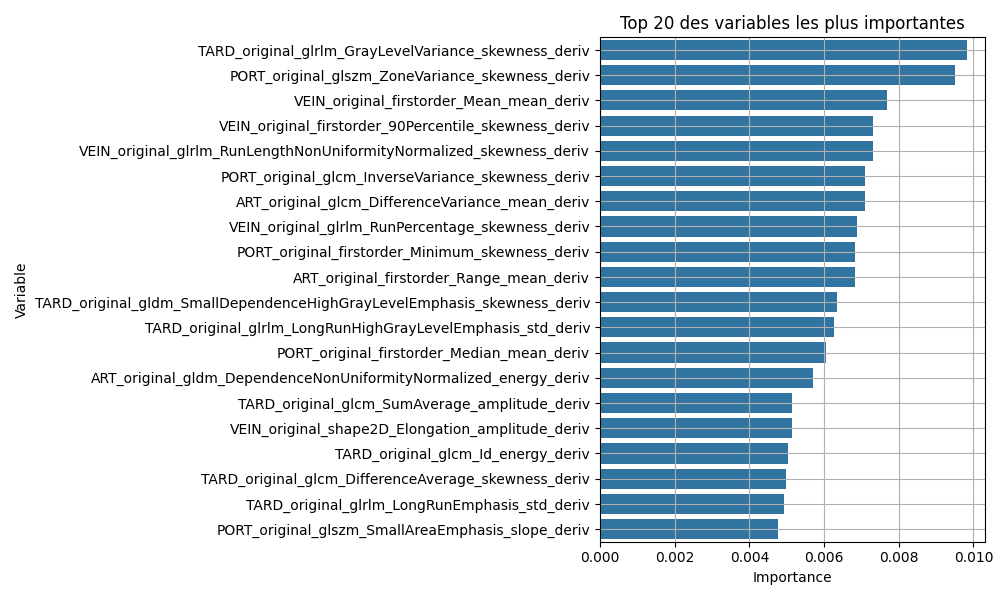

              precision    recall  f1-score   support

      Vivant       0.75      0.43      0.55        14
      Décédé       0.43      0.75      0.55         8

    accuracy                           0.55        22
   macro avg       0.59      0.59      0.55        22
weighted avg       0.63      0.55      0.55        22



In [5]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler




# Cible : décès
y = df['Death'].fillna(0).astype(int)

# Préparation des données
X = df.drop(columns=['patient_num', 'classe_name', 'temps_inj', 'Death'], errors='ignore')
X = X.applymap(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)
X = X.astype(float)
# Imputation et normalisation
X_imputed = SimpleImputer(strategy='mean').fit_transform(X)
X_scaled = StandardScaler().fit_transform(X_imputed)

# PCA
pca = PCA(n_components=25)
X_pca = pca.fit_transform(X_scaled)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# Réduction du déséquilibre
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
feature_names = X.columns

# Entraînement
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
clf.fit(X_resampled, y_resampled)

# Prédiction
y_pred = clf.predict(X_test)

# Rapport
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 20  # Nombre de variables à afficher

# Affichage
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices[:top_n]], y=feature_names[indices[:top_n]])
plt.title("Top 20 des variables les plus importantes")
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.grid(True)
plt.tight_layout()
plt.show()
print(classification_report(y_test, y_pred, target_names=['Vivant', 'Décédé']))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np
from imblearn.under_sampling import RandomUnderSampler

# Cible = décès (1 si mort, 0 sinon)
y = df['Death'].fillna(0).astype(int)  # Assure-toi que NaN devient 0 (non mort)

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# Rééquilibrage des classes si nécessaire
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Entraînement du modèle
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_resampled, y_resampled)

# Prédictions
y_pred = clf.predict(X_test)

# Rapport
print(classification_report(y_test, y_pred, target_names=['Vivant', 'Décédé']))

              precision    recall  f1-score   support

      Vivant       0.75      0.43      0.55        14
      Décédé       0.43      0.75      0.55         8

    accuracy                           0.55        22
   macro avg       0.59      0.59      0.55        22
weighted avg       0.63      0.55      0.55        22

